In [1]:
import os
import pandas as pd
from mapboxgl.viz import *
from mapboxgl.utils import *
import warnings
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

warnings.filterwarnings(action='ignore', category=UserWarning)
# import pysal.esda.mapclassify as mapclassify
# import folium

# Setup paths
script_dir = os.path.abspath('')
project_dir =  os.path.dirname(os.path.abspath(''))
data_dir = os.path.join(project_dir, 'data')

# import data
df_parties = pd.read_excel(os.path.join(data_dir, r'Circuit Clerk Data', r'Parties_2005-01-01_thru_2018-12-31.xlsx'))
df_judgement = pd.read_excel(os.path.join(data_dir, r'Circuit Clerk Data', r'Judgments_2005-01-01_thru_2018-12-31.xlsx'))

In [2]:
df_parties.head()

,state,county,casenbr,partytype,name,address,csz
0,IL,PEORIA,00-LM-01633,A,pro se,NaN,NaN
1,IL,PEORIA,00-LM-01633,A,"BURRIER, GEORGE",701 E.POLK,"MORTON, IL 61550"
2,IL,PEORIA,00-LM-01633,D,"BLANCO, YOLANDA",711 VINE STREET,"PEORIA, IL 61603"
3,IL,PEORIA,00-LM-01633,P,"MARLING MANAGEMENT, INC",NaN,NaN
4,IL,PEORIA,02-LM-00949,A,KAVANAGH SCULLY SUDOW WHITE & FREDERICK,301 SW ADAMS ST STE 700,"PEORIA, IL 61602"


In [3]:
df_judgement.head()

,state,county,casenbr,datefiled,judgmentdate,favorpartytype,amount,additional
0,IL,PEORIA,00-LM-01633,2000-08-28,2007-11-21,NaN,NaN,NaN
1,IL,PEORIA,02-LM-00949,2002-06-04,2005-11-15,NaN,NaN,NaN
2,IL,PEORIA,04-LM-00005,2004-01-05,2005-04-06,NaN,NaN,NaN
3,IL,PEORIA,04-LM-00189,2004-01-23,2005-03-10,NaN,NaN,NaN
4,IL,PEORIA,04-LM-00432,2004-03-02,2005-08-02,NaN,NaN,NaN


In [4]:
df = pd.merge(df_parties.drop(['state', 'county'], axis=1), df_judgement)
df['full_address'] = df.address.str.strip().str.cat(df.csz.str.strip(), sep=', ')

In [5]:
df.drop_duplicates(inplace=True)
df.head()

,casenbr,partytype,name,address,csz,state,county,datefiled,judgmentdate,favorpartytype,amount,additional,full_address
0,00-LM-01633,A,pro se,NaN,NaN,IL,PEORIA,2000-08-28,2007-11-21,NaN,NaN,NaN,NaN
1,00-LM-01633,A,"BURRIER, GEORGE",701 E.POLK,"MORTON, IL 61550",IL,PEORIA,2000-08-28,2007-11-21,NaN,NaN,NaN,"701 E.POLK, MORTON, IL 61550"
2,00-LM-01633,D,"BLANCO, YOLANDA",711 VINE STREET,"PEORIA, IL 61603",IL,PEORIA,2000-08-28,2007-11-21,NaN,NaN,NaN,"711 VINE STREET, PEORIA, IL 61603"
3,00-LM-01633,P,"MARLING MANAGEMENT, INC",NaN,NaN,IL,PEORIA,2000-08-28,2007-11-21,NaN,NaN,NaN,NaN
4,02-LM-00949,A,KAVANAGH SCULLY SUDOW WHITE & FREDERICK,301 SW ADAMS ST STE 700,"PEORIA, IL 61602",IL,PEORIA,2002-06-04,2005-11-15,NaN,NaN,NaN,"301 SW ADAMS ST STE 700, PEORIA, IL 61602"


Index(['casenbr', 'partytype', 'name', 'address', 'csz', 'state', 'county',
       'datefiled', 'judgmentdate', 'favorpartytype',
       ...
       'Census Block Code', 'Census Block Group', 'Full FIPS',
       'Metro/Micro Statistical Area Name',
       'Metro/Micro Statistical Area Code',
       'Metro/Micro Statistical Area Type', 'Combined Statistical Area Name',
       'Combined Statistical Area Code', 'Metropolitan Division Area Name',
       'Metropolitan Division Area Code'],
      dtype='object', length=253)

In [6]:
mapbox_access_token = r'pk.eyJ1IjoiYWFnb3N0aW5pLXBlb3JpYWdvdiIsImEiOiJjanlydGdhMWUwMmkyM2Nxa3pzM3VxeTd3In0.lu4TL9ssZokx1h-9VABwdA' #Special token which will be revoked after the hackathon.

In [7]:
df_evictions = pd.read_csv(os.path.join(data_dir, 'peoria_evictions_2000_to_2018_geocodio.csv'), low_memory=False, parse_dates = ['judgmentdate', 'datefiled'])
token = os.getenv('MAPBOX_ACCESS_TOKEN', mapbox_access_token)

In [8]:
# Map locations of all available recorded evictions for the selected year (set by the interactive slider below)
df_evictions_core_columns = df_evictions[['full_address','Latitude','Longitude','favorpartytype','judgmentdate']]
@interact
def map_evictions(year=(2000, 2019, 1)):
    # Create a geojson file export from a Pandas dataframe
    data = df_to_geojson(df_evictions_core_columns[df_evictions_core_columns.judgmentdate.dt.year==year],
                 properties=['full_address'],
                  lat='Latitude', lon='Longitude', precision=6)

    # Create the viz from the dataframe
    viz = CircleViz(data,
                    access_token=token, 
                    height='900px',
                    color_default = 'rgb(44,127,184)',
                    opacity = 0.3,
                    radius = 2,
                    center = (-89.593572, 40.730991),
                    zoom = 11.3,
                    below_layer = 'waterway-label')

    viz.style = r"mapbox://styles/aagostini-peoriagov/cjuspc2zu01l41fo543e5063o"
    viz.show()

interactive(children=(IntSlider(value=2009, description='year', max=2019, min=2000), Output()), _dom_classes=(…

In [9]:
# Map locations of all available recorded evictions for the full dataset (Across all time)
token = os.getenv('MAPBOX_ACCESS_TOKEN', mapbox_access_token)

# Create a geojson file export from a Pandas dataframe
data = df_to_geojson(df_evictions[['full_address','Latitude','Longitude','favorpartytype']].head(20000),
             properties=['full_address'],
              lat='Latitude', lon='Longitude', precision=6)

# Create the viz from the dataframe
viz = CircleViz(data,
                access_token=token, 
                height='900px',
                color_default = 'rgb(44,127,184)',
                opacity = 0.3,
                radius = 2,
                center = (-89.593572, 40.730991),
                zoom = 11.3,
                below_layer = 'waterway-label')

viz.style = r"mapbox://styles/aagostini-peoriagov/cjuspc2zu01l41fo543e5063o"
viz.show()

In [10]:
## What's the distrubution of favored party type?
df[['casenbr','favorpartytype']].groupby(['casenbr','favorpartytype']).size().reset_index().favorpartytype.value_counts()

P    4955
D       7
Name: favorpartytype, dtype: int64

In [11]:
df[['casenbr','favorpartytype']].groupby(['casenbr','favorpartytype']).size().reset_index().favorpartytype.value_counts(normalize=True)

P    0.998589
D    0.001411
Name: favorpartytype, dtype: float64

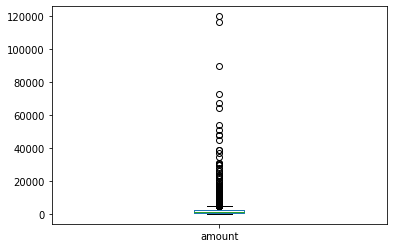

In [12]:
#What's the distribution of a judgement amounts?
df[['casenbr','amount']].groupby(['casenbr','amount']).size().reset_index().amount.plot.box()

In [13]:
df[['casenbr','amount']].groupby(['casenbr','amount']).size().reset_index().amount.describe()

count      4348.000000
mean       2188.911621
std        4516.906654
min           0.000000
25%         823.435000
50%        1400.000000
75%        2352.945000
max      120000.000000
Name: amount, dtype: float64

In [14]:
# What's the time between when eviction paperwork is filed and a judgement is passed? 
df['days_until_judgement'] = df.judgmentdate - df.datefiled
df['days_until_judgement'].describe()

count                       62794
mean      37 days 20:35:58.371818
std      117 days 14:50:09.343161
min               1 days 00:00:00
25%              15 days 00:00:00
50%              21 days 00:00:00
75%              35 days 00:00:00
max            5401 days 00:00:00
Name: days_until_judgement, dtype: object

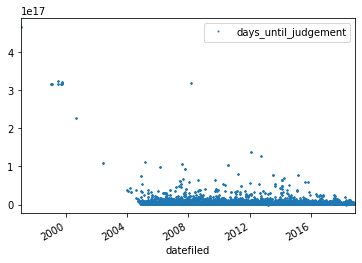

In [15]:
# How does 
df.plot(x="datefiled",y="days_until_judgement",style="o",ms=1)

In [16]:
# Who is involved in really expensive evictions?
df_high_amounts = df[['casenbr','amount']].groupby(['casenbr','amount']).size().reset_index()

In [17]:
df[df.casenbr.isin(df_high_amounts[df_high_amounts.amount > 10000].casenbr)]

,casenbr,partytype,name,address,csz,state,county,datefiled,judgmentdate,favorpartytype,amount,additional,full_address,days_until_judgement
52748,13-LM-00338,A,pro se,NaN,NaN,IL,PEORIA,2013-03-15,2014-02-11,P,10642.00,1012ne madison peoria il,NaN,333 days
52749,13-LM-00338,A,KAVANAGH SCULLY SUDOW WHITE & FREDERICK,301 SW ADAMS ST STE 700,"PEORIA, IL 61602",IL,PEORIA,2013-03-15,2014-02-11,P,10642.00,1012ne madison peoria il,"301 SW ADAMS ST STE 700, PEORIA, IL 61602",333 days
52750,13-LM-00338,D,"ALLEN, TAMIKA",1012 NE MADISON,"PEORIA, IL 61603",IL,PEORIA,2013-03-15,2014-02-11,P,10642.00,1012ne madison peoria il,"1012 NE MADISON, PEORIA, IL 61603",333 days
52751,13-LM-00338,P,PEORIA HOUSING AUTHORITY,NaN,NaN,IL,PEORIA,2013-03-15,2014-02-11,P,10642.00,1012ne madison peoria il,NaN,333 days
55501,13-LM-01208,A,HOWARD AND HOWARD,211 FULTON ST. SUITE 600,"PEORIA, IL 61602",IL,PEORIA,2013-08-19,2015-04-28,P,67283.04,PLUS ATTY FEES OF 5856.00,"211 FULTON ST. SUITE 600, PEORIA, IL 61602",617 days
55502,13-LM-01208,A,HOWARD AND HOWARD,211 FULTON ST. SUITE 600,"PEORIA, IL 61602",IL,PEORIA,2013-08-19,2015-02-20,P,NaN,POSSESSION ONLY,"211 FULTON ST. SUITE 600, PEORIA, IL 61602",550 days
55503,13-LM-01208,A,CULTER & HULL,"70 W MAIDSON ST SUITE 400 CHICAGO, IL 60602",NaN,IL,PEORIA,2013-08-19,2015-04-28,P,67283.04,PLUS ATTY FEES OF 5856.00,NaN,617 days
55504,13-LM-01208,A,CULTER & HULL,"70 W MAIDSON ST SUITE 400 CHICAGO, IL 60602",NaN,IL,PEORIA,2013-08-19,2015-02-20,P,NaN,POSSESSION ONLY,NaN,550 days
55505,13-LM-01208,D,"BRANDYWINE 2, LLC",4114 BRANDYWINE DR,"PEORIA, IL 61614",IL,PEORIA,2013-08-19,2015-04-28,P,67283.04,PLUS ATTY FEES OF 5856.00,"4114 BRANDYWINE DR, PEORIA, IL 61614",617 days
55506,13-LM-01208,D,"BRANDYWINE 2, LLC",4114 BRANDYWINE DR,"PEORIA, IL 61614",IL,PEORIA,2013-08-19,2015-02-20,P,NaN,POSSESSION ONLY,"4114 BRANDYWINE DR, PEORIA, IL 61614",550 days
